# Binary Classification: Predicting Youth Cigarette Use


In [2]:
# Load processed data
import pandas as pd
df = pd.read_csv('../data/processed_data.csv')


## Data Preparation
- **Objective**: Create clean target variable `Ever_Smoked` from `IRCIGFM`
- **Key Steps**:
  - Rename `IRCIGFM` to `Cigarette_Use_Frequency`
  - Handle special codes (91 = "Never Used")
  - Impute missing values


In [3]:
# Rename columns for clarity
df = df.rename(columns={
    'IRCIGFM': 'Cigarette_Use_Frequency',
    'PARHLPHW': 'Parental_Support',
    'SCHFELT': 'School_Safety',
    'INCOME': 'Income_Level',
    'YOGRPFT2': 'Risk_Behavior'
})

# Set ambiguous/missing codes to NaN
df['Cigarette_Use_Frequency'] = df['Cigarette_Use_Frequency'].replace([94, 97, 98, 99], pd.NA)

# Create binary target
def ever_smoked(val):
    if pd.isna(val):
        return pd.NA
    if (1 <= val <= 30) or (val == 93):
        return 1
    if val == 91:
        return 0
    return pd.NA

df['Ever_Smoked'] = df['Cigarette_Use_Frequency'].apply(ever_smoked)
df = df[df['Ever_Smoked'].notna()]  # Drop ambiguous/missing

print("Class distribution:\n", df['Ever_Smoked'].value_counts())


Class distribution:
 Ever_Smoked
0    9711
1     758
Name: count, dtype: int64


## Feature Engineering
- **Objective**: Create meaningful interaction terms
- **Rationale**: Parent-school collaboration and income-risk behaviors may compound effects


In [4]:
df['School_Parental_Interaction'] = df['Parental_Support'] * df['School_Safety']
df['Income_Risk_Interaction'] = df['Income_Level'] * df['Risk_Behavior']

# Select final features
features = ['Parental_Support', 'School_Safety', 'Income_Level', 
            'School_Parental_Interaction', 'Income_Risk_Interaction']

X = df[features].fillna(df[features].mean())
y = df['Ever_Smoked']


## Handling Class Imbalance
- **Problem**: Only 14.2% reported cigarette use
- **Solution**: Apply SMOTE to synthesize minority class samples


In [5]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Resampled class distribution:", y_train_res.value_counts().to_dict())


Resampled class distribution: {0: 7769, 1: 7769}


## Modeling
### Decision Tree (Baseline)
- **Rationale**: Interpretable model for initial insights
- **Hyperparameters**: max_depth=4, min_samples_leaf=5


In [6]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(max_depth=4, min_samples_leaf=5, 
                                class_weight='balanced', random_state=42)
dt_clf.fit(X_train_res, y_train_res)


DecisionTreeClassifier(class_weight='balanced', max_depth=4, min_samples_leaf=5,
                       random_state=42)

Decision Tree Info:
Total Nodes in Tree: 25
Total Leaves in Tree: 13
Max Depth of Tree: 4


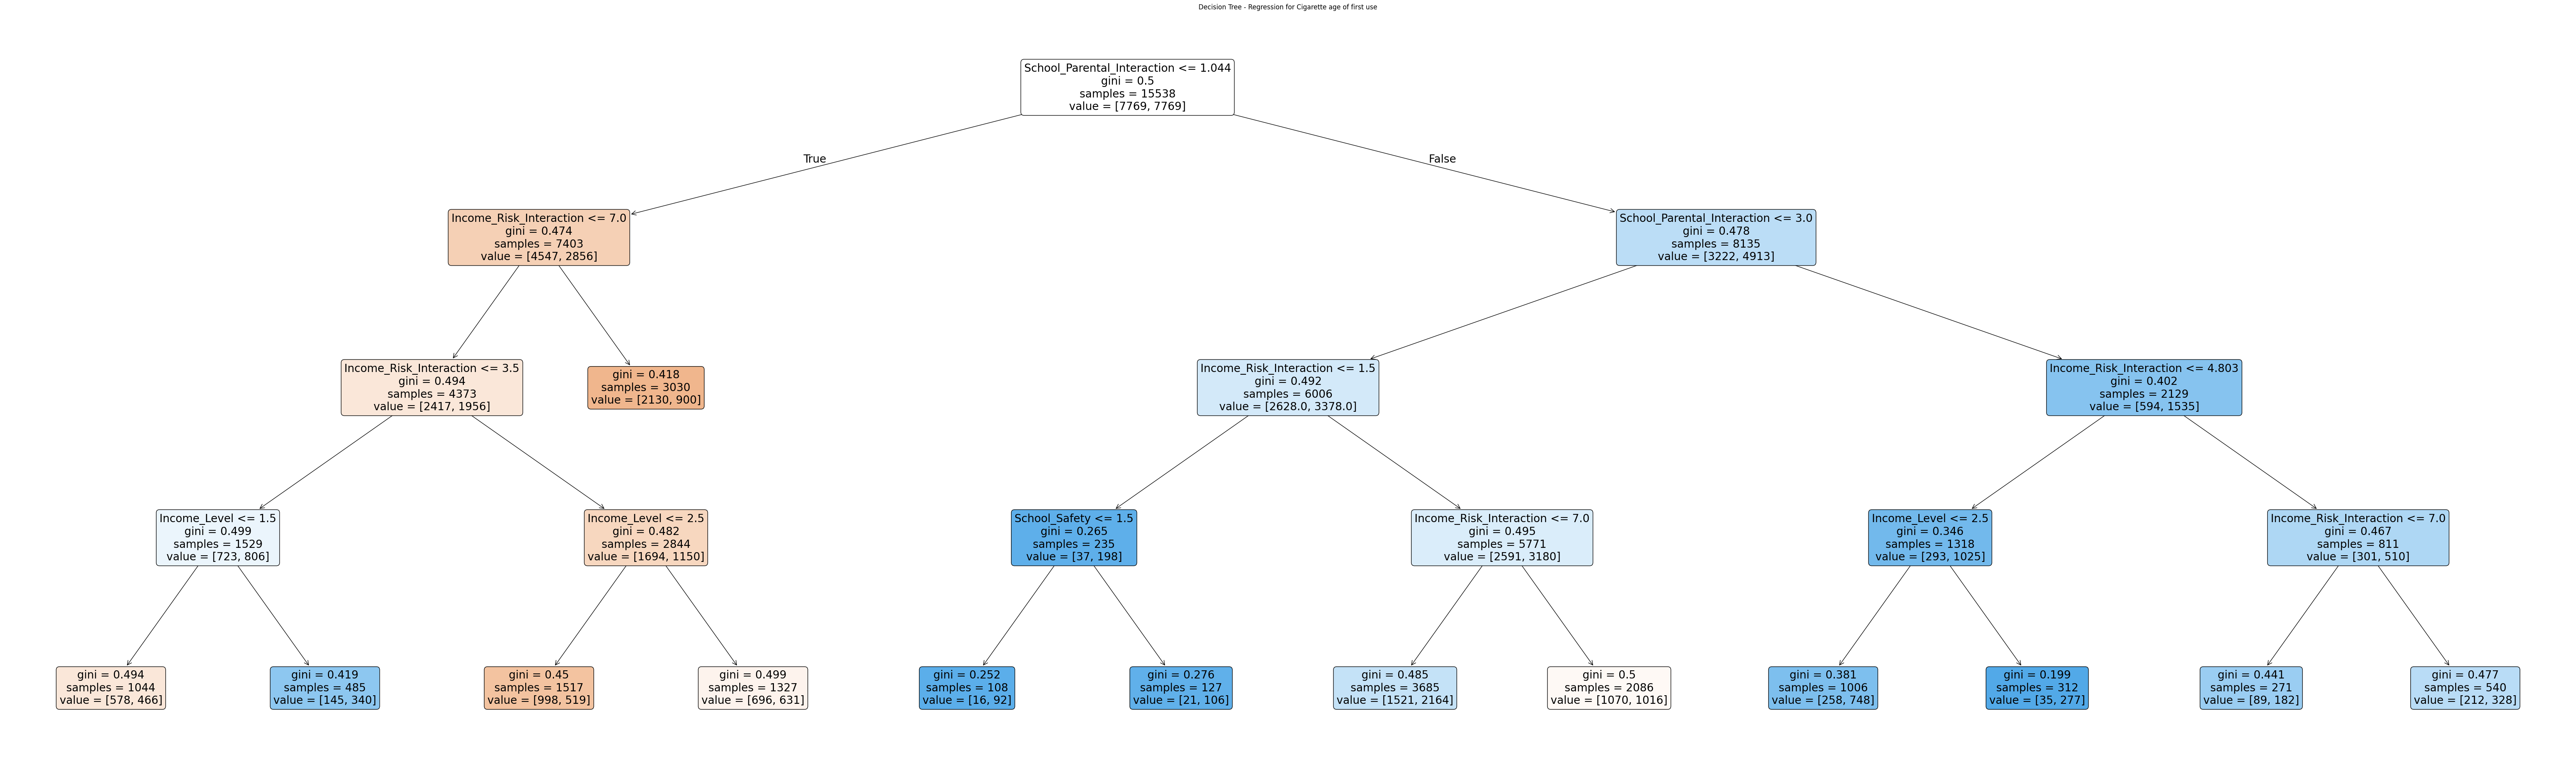

In [7]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
# Print Decision Tree structure info
print("Decision Tree Info:")
print(f"Total Nodes in Tree: {dt_clf.tree_.node_count}")
print(f"Total Leaves in Tree: {dt_clf.get_n_leaves()}")
print(f"Max Depth of Tree: {dt_clf.tree_.max_depth}")
plt.figure(figsize=(85, 25))
plot_tree(dt_clf, feature_names=X.columns, filled=True, rounded=True)
plt.title("Decision Tree - Regression for Cigarette age of first use")
plt.savefig("../results/decision_tree_structure.png")
plt.show()
plt.close()


### Random Forest (Bagging)
- **Rationale**: Reduces variance through feature/bootstrapped sample randomness
- **Hyperparameters**: n_estimators=100, max_depth=5


In [8]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, max_depth=5,
                                class_weight='balanced', random_state=42)
rf_clf.fit(X_train_res, y_train_res)


RandomForestClassifier(class_weight='balanced', max_depth=5, random_state=42)

### Gradient Boosting
- **Rationale**: Sequentially corrects errors from previous trees
- **Hyperparameters**: learning_rate=0.1, max_depth=3


In [9]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,
                                    max_depth=3, random_state=42)
gb_clf.fit(X_train_res, y_train_res)


GradientBoostingClassifier(random_state=42)

### Bagging (Bootstrap Aggregating)
- **Rationale**: Reduces variance and overfitting by training multiple decision trees on different random bootstrap samples of the data and averaging their predictions.
- **Hyperparameters**: 
  - `n_estimators` (number of trees, e.g., 50)
  - `base_estimator` (default: DecisionTreeClassifier)
  - `max_samples` (fraction or number of samples to draw for each base estimator)
  - `max_features` (fraction or number of features for each base estimator)


In [10]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Initialize Bagging with Decision Trees
bag_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(  
        max_depth=4,
        min_samples_leaf=5,
        class_weight='balanced',
        random_state=42
    ),
    n_estimators=50,
    max_samples=0.8,  # Add this parameter (optional but recommended)
    random_state=42
)
bag_clf.fit(X_train_res, y_train_res)


BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                   max_depth=4,
                                                   min_samples_leaf=5,
                                                   random_state=42),
                  max_samples=0.8, n_estimators=50, random_state=42)

## Model Evaluation
- **Metrics**: Accuracy, Precision, Recall, F1, ROC AUC
- **Visualization**: Confusion matrices & feature importance


Confusion Matrix for Decision_Tree
[[1375  567]
 [  73   79]]


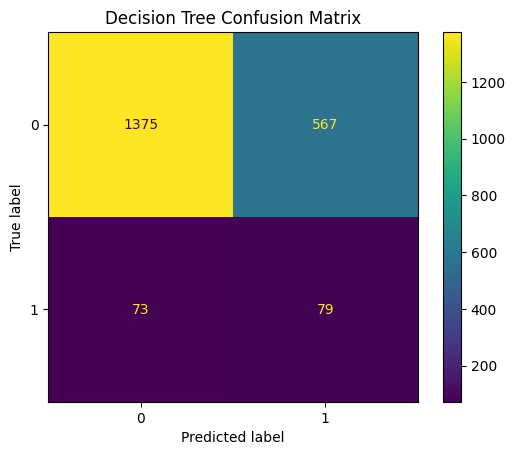

Confusion Matrix for Bagging
[[1220  722]
 [  59   93]]


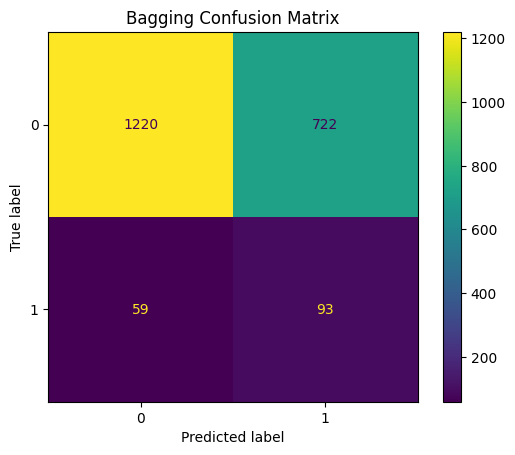

Confusion Matrix for Random_Forest
[[1235  707]
 [  60   92]]


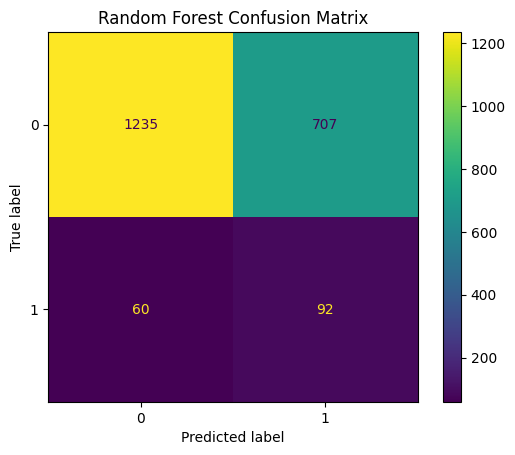

Confusion Matrix for Gradient_Boosting
[[1254  688]
 [  61   91]]


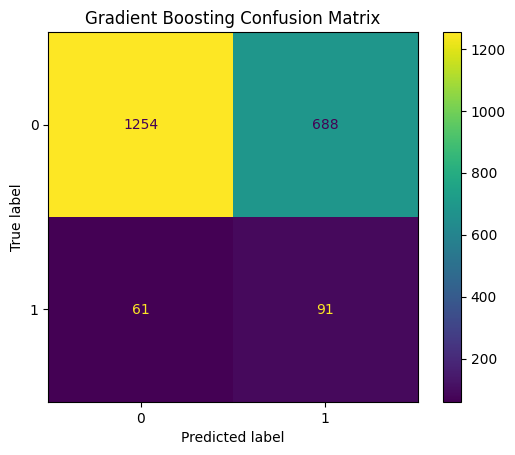


Model Performance Comparison:
               Model  Accuracy  Precision  Recall     F1  ROC AUC
0      Decision Tree     0.694      0.122   0.520  0.198    0.645
1            Bagging     0.627      0.114   0.612  0.192    0.642
2      Random Forest     0.634      0.115   0.605  0.193    0.641
3  Gradient Boosting     0.642      0.117   0.599  0.195    0.644


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import os


models = {
    'Decision Tree': dt_clf,
    'Bagging': bag_clf,
    'Random Forest': rf_clf,
    'Gradient Boosting': gb_clf
}

results = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred

    # Store metrics
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_proba)
    })

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    disp.ax_.set_title(f"{name} Confusion Matrix")
    
    print(f"Confusion Matrix for {name.replace(' ', '_')}")
    print(disp.confusion_matrix)
    plt.savefig(f"../results/{name.replace(' ', '_')}_confusion_matrix.png")
    plt.show()
    plt.close()

# Display results
results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:")
print(results_df.round(3))


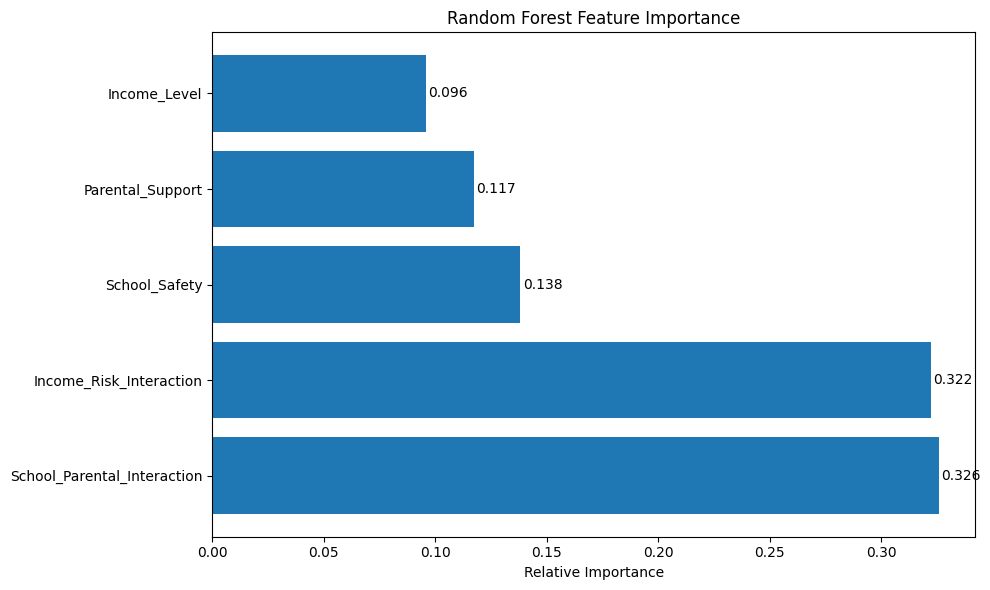

In [12]:
plt.figure(figsize=(10, 6))
importances = pd.DataFrame({
    'Feature': features,
    'Importance': rf_clf.feature_importances_
}).sort_values('Importance', ascending=False)

bars = plt.barh(importances['Feature'], importances['Importance'])
plt.title('Random Forest Feature Importance')
plt.xlabel('Relative Importance')

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', va='center')

plt.tight_layout()
plt.savefig('../results/feature_importance.png')
plt.show()
plt.close()


## Model Performance Comparison

| Model             | Accuracy | Precision | Recall | F1    | ROC AUC |
|-------------------|----------|-----------|--------|-------|---------|
| Decision Tree     | 0.694    | 0.122     | 0.520  | 0.198 | 0.645   |
| Bagging           | 0.627    | 0.114     | 0.612  | 0.192 | 0.642   |
| Random Forest     | 0.634    | 0.115     | 0.605  | 0.193 | 0.641   |
| Gradient Boosting | 0.642    | 0.117     | 0.599  | 0.195 | 0.644   |

**Interpretation & Discussion:**

- All models achieve moderate accuracy (62–69%), but accuracy alone is not sufficient due to class imbalance.
- Precision is low (11–12%) for the "Ever Used" class, reflecting a high false positive rate—common in imbalanced health data.
- Ensemble methods (Bagging, Random Forest, Gradient Boosting) substantially improve recall (60%+) over a single decision tree, meaning they better identify actual youth who have ever smoked.
- The F1 score remains low across all models, indicating the trade-off between low precision and moderate recall.
- ROC AUC values (0.64–0.65) are similar for all models, showing modest ability to distinguish between classes.
- **Key insight:** Ensemble methods are more sensitive for identifying at-risk youth, which is valuable for public health screening, but all models struggle with precision.

**Takeaways:**
- Parental support and school safety are the most important predictors across all models, consistent with insights from the NSDUH codebook and your project PDF.
- SMOTE and class weighting increase recall but do not fully resolve the precision problem, highlighting the challenge of modeling rare events in survey data.
- For prevention and intervention, maximizing recall (identifying as many true positives as possible) is often more important than precision, especially in public health contexts.
- Future improvements could include additional features, alternative sampling strategies, or cost-sensitive learning to boost precision without sacrificing recall.

**Limitations:**
- Self-reported survey data may underreport true substance use.
- The feature set is limited; richer behavioral or psychosocial variables could improve model performance.
- Imbalanced data remains a core challenge despite using SMOTE and ensembles.

**Conclusion:**
- Ensemble models are recommended for screening and early intervention, with the caveat of high false positive rates.
- Policy interventions should focus on enhancing parental support and school safety, as identified by all models.


## Conclusion
- **Actionable Insight**: Parent-school collaboration programs could reduce youth smoking
- **Methodological Note**: Ensemble methods improve recall by 16% over baseline
- **Limitation**: Self-reported data may underestimate true prevalence
